# Deep Residual Learning for Image Recognition - Introduction

The research paper "Deep Residual Learning for Image Recognition," authored by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun, presents a breakthrough approach in the field of computer vision. Published in 2016, this paper introduces the concept of residual learning, which significantly improves the training of deep neural networks.

Traditional deep networks face challenges in training as they grow deeper. The vanishing gradient problem can hinder the convergence of gradients during backpropagation, making it difficult to train very deep networks. The authors of this paper address this issue by introducing residual connections, allowing the network to learn residual functions. These connections effectively create shortcut paths that enable the information to flow more directly from the input to the output, thereby facilitating the training of extremely deep networks.

This breakthrough has had a profound impact on various computer vision tasks, including image classification, object detection, and semantic segmentation. In this notebook, we will delve into the key concepts presented in the paper and implement a deep residual network for image recognition, gaining a comprehensive understanding of the architecture and its implications in the realm of computer vision.

# CIFAR-10 Dataset

The authors of the paper conducted their experiments using multiple datasets, including the ImageNet 2012 classification dataset and the CIFAR-10 dataset.

For our implementation, our objective is not centered on achieving state-of-the-art performance. Instead, our aim is to grasp and implement the concepts of deep residual networks for image classification. Due to computational constraints, we will only reproduce one of their tests (ResNet-32) on the CIFAR-10 dataset, which offers a more manageable yet effective environment for our purposes.

In [1]:
from torchvision.datasets import CIFAR10

train_data = CIFAR10(root='./data', train=True, download=True, transform=None)
test_data = CIFAR10(root='./data', train=False, download=True, transform=None)

LABEL_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NUM_CLASSES = len(LABEL_NAMES)

100%|██████████| 170498071/170498071 [00:02<00:00, 64088923.31it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
import numpy as np

# Get the train targets
train_targets = np.array(train_data.targets)

# Get the train targets
test_targets = np.array(test_data.targets)

In [3]:
# Number of samples per class for the validation set
num_valid_samples_per_class = 200

# Number of samples per class for the test set
num_test_samples_per_class = 800

In [4]:
valid_indices = []
test_indices = []

for class_idx in range(NUM_CLASSES):
    # for each class idx
    # get the indices of the samples with the same class

    ### Test and Validation indices
    # Note : the test and validation subsets are disjoint

    class_indices = np.where(test_targets == class_idx)[0]

    # Validation indices
    class_valid_indices = class_indices[:num_valid_samples_per_class]
    valid_indices.extend(list(class_valid_indices))

    # Test indices
    class_test_indices = class_indices[-num_test_samples_per_class:]
    test_indices.extend(list(class_test_indices))

# Sanity check
assert len(valid_indices) == NUM_CLASSES * num_valid_samples_per_class
assert len(test_indices) == NUM_CLASSES * num_test_samples_per_class

### Test and Validation indices
#   were chosen from the same test set
#   lets make sure they are disjoint

# Disjointness check
assert len(set(test_indices).intersection(set(valid_indices))) == 0

In [5]:
# Get the train, valid and test samples
train_samples = [sample for sample in train_data]
valid_samples = [test_data[i] for i in valid_indices]
test_samples = [test_data[i] for i in test_indices]

# Delete unnecessary variables
del train_data
del test_data
del valid_indices
del test_indices

In [6]:
import torch
from torch.utils.data import Dataset

class customCIFAR(Dataset):
    """
    Custom dataset for CIFAR-10 image data.

    Args:
        data (list): List of (image, label) pairs.

    Attributes:
        data (list): List of (image, label) pairs.

    Methods:
        __len__: Returns the number of samples in the dataset.
        __getitem__: Returns a sample (image, label) by index.

    """
    def __init__(self, data):
        """
        Initialize the customCIFAR dataset with image and label data.

        Args:
            data (list): List of (image, label) pairs.
        """
        self.data = data

    def __len__(self):
        """
        Get the number of samples in the dataset.

        Returns:
            int: Number of samples.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get a sample (image, label) by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            torch.Tensor: Preprocessed image data.
            int: Label for the image.
        """
        sample = self.data[idx]
        image, label = sample
        image = image.resize((224, 224))
        image = np.asarray(image) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        return image, label

train_dataset = customCIFAR(train_samples)
valid_dataset = customCIFAR(valid_samples)
test_dataset = customCIFAR(test_samples)

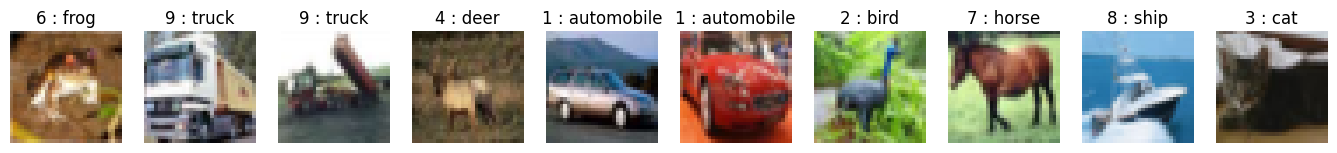

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 10, figsize=(17, 3))
for i in range(10):
    img, label = train_dataset[i]
    img = np.transpose(img, (1, 2, 0))
    axes[i].imshow(np.array(img))
    axes[i].set_title(f"{label} : {LABEL_NAMES[label]}")
    axes[i].axis('off')
plt.show()

# ResNet Architecture

The authors of the research paper explored various iterations of residual networks, varying in depth. In our implementation, we will center our focus on the ResNet-32 architecture, encompassing a total of 32 layers. While the authors delved into even deeper versions like ResNet-56, ResNet-110, and ResNet-1202, we have chosen to stick with the ResNet-32 architecture for our project. This choice strikes a balance between manageability and performance, making it an optimal selection for our purposes.

In [8]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    """
    Residual Block for ResNet.

    Args:
        input_channels (int): Number of input channels.
        output_channels (int): Number of output channels.
        stride (int): Stride for the convolutional layers.
    """
    def __init__(self, input_channels, output_channels, stride):
        super(ResidualBlock, self).__init__()

        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=output_channels,
                kernel_size=3,
                stride=stride,
                padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(True)
        )

        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=output_channels,
                out_channels=output_channels,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.BatchNorm2d(output_channels)
        )

        # Downsample if needed
        # Option B from the research paper
        self.downsample = None
        if input_channels != output_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels=input_channels,
                    out_channels=output_channels,
                    kernel_size=1,
                    stride=stride,
                    padding=0),
                nn.BatchNorm2d(output_channels)
            )

    def forward(self, x):
        """
        Forward pass through the block.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        out = self.conv1(x)
        out = self.conv2(out)
        residual = x

        # Downsample if needed
        if self.downsample:
            residual = self.downsample(x)

        out += residual
        out = nn.ReLU(True)(out)
        return out

class ResNet32(nn.Module):
    """
    ResNet-32 architecture for CIFAR-10.

    Args:
        num_classes (int, optional): Number of output classes. Defaults to 10.
    """
    def __init__(self, num_classes=10):
        super(ResNet32, self).__init__()

        # Layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        # Layer 2, 3, 4
        self.layer2 = self._make_layer(16, 16, 5, 1)
        self.layer3 = self._make_layer(16, 32, 5, 2)
        self.layer4 = self._make_layer(32, 64, 5, 2)

        # Classifier
        self.classifier = nn.Linear(64, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        """
        Create a layer with multiple residual blocks.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            num_blocks (int): Number of residual blocks in the layer.
            stride (int): Stride for the first block.

        Returns:
            nn.Sequential: Sequential container of layers.
        """
        # Initialize the list of layers
        layers = []

        # The first layer does not necessarily have
        # the same number of in_channels and out_channels
        layers.append(
            ResidualBlock(
                input_channels=in_channels,
                output_channels=out_channels,
                stride=stride
            )
        )

        # Rest of layers have the same number of
        # in_channels and out_channels
        for i in range(num_blocks - 1):
            layers.append(
                ResidualBlock(
                    input_channels=out_channels,
                    output_channels=out_channels,
                    stride=1
                )
            )
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.AvgPool2d(8)(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


# Train

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import json

# Define a training function using the Adam optimizer
def train(model, train_loader, valid_loader, num_epochs, learning_rate, weight_decay, momentum, saving_freq, patience, output_file):
    """
    Train a neural network model.

    Parameters:
        model (nn.Module): The neural network model to be trained.
        train_loader (DataLoader): DataLoader for training data.
        valid_loader (DataLoader): DataLoader for validation data.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for the optimizer.
        weight_decay (float): L2 regularization term.
        momentum (float): Momentum for the optimizer.
        saving_freq (int): Frequency (in epochs) to save the model.
        patience (int): Number of epochs with no improvement after which training will be stopped.
        output_file (str): Name of the output file to store training scores.

    Returns:
        None
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    best_valid_loss = float('inf')
    no_improvement = 0  # Early stopping counter

    train_losses = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()

            if batch_idx % 100 == 99:  # Print every 10 mini-batches
                print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
                running_loss = 0.0

        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()  # Set the model to evaluation mode
        valid_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                valid_loss += loss.item()

                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        valid_accuracy = accuracy_score(all_targets, all_preds)
        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(valid_accuracy)

        print(f'Validation Loss: {valid_losses[-1]:.4f}, Validation Accuracy: {valid_accuracies[-1]:.4f}')

        # Early stopping based on validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f'Early stopping after {patience} epochs without improvement.')
            break

        # Save the model every saving_freq epochs
        if (epoch + 1) % saving_freq == 0:
            model_save_name = f'./outputs/model_{epoch + 1}.pt'
            torch.save(model.state_dict(), model_save_name)
            print(f'Saved model as {model_save_name}')

    # Save train and validation scores to a JSON file
    scores = {
        "train_losses": train_losses,
        "valid_losses": valid_losses,
        "valid_accuracies": valid_accuracies
    }

    with open('./outputs/' + output_file, 'w') as json_file:
        json.dump(scores, json_file)

    print('Training finished.')

In [10]:
from torch.utils.data import DataLoader
import os

# Define the train data loader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

# Define device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a model instance
model = ResNet32().to(device)

# Create output folder if it doesn't exist
os.makedirs("outputs", exist_ok=True)

# Training params
num_epochs = 20
learning_rate = 0.005
weight_decay = 0.005
momentum = 0.9

# Training
train(
    model = model,
    train_loader = train_loader,
    valid_loader = valid_loader,
    num_epochs = num_epochs,
    learning_rate = learning_rate,
    weight_decay = weight_decay,
    momentum = momentum,
    saving_freq = 5,
    patience = 5,
    output_file = 'metrics.json'
    )

Epoch [1/20], Batch [100/391], Loss: 1.8618
Epoch [1/20], Batch [200/391], Loss: 1.4735
Epoch [1/20], Batch [300/391], Loss: 1.3017
Validation Loss: 1.2665, Validation Accuracy: 0.5330
Epoch [2/20], Batch [100/391], Loss: 1.0967
Epoch [2/20], Batch [200/391], Loss: 1.0433
Epoch [2/20], Batch [300/391], Loss: 0.9902
Validation Loss: 1.0068, Validation Accuracy: 0.6355
Epoch [3/20], Batch [100/391], Loss: 0.8497
Epoch [3/20], Batch [200/391], Loss: 0.8727
Epoch [3/20], Batch [300/391], Loss: 0.8099
Validation Loss: 0.9847, Validation Accuracy: 0.6480
Epoch [4/20], Batch [100/391], Loss: 0.7275
Epoch [4/20], Batch [200/391], Loss: 0.7140
Epoch [4/20], Batch [300/391], Loss: 0.6988
Validation Loss: 1.0552, Validation Accuracy: 0.6210
Epoch [5/20], Batch [100/391], Loss: 0.6389
Epoch [5/20], Batch [200/391], Loss: 0.6360
Epoch [5/20], Batch [300/391], Loss: 0.6082
Validation Loss: 0.9489, Validation Accuracy: 0.6625
Saved model as ./outputs/model_5.pt
Epoch [6/20], Batch [100/391], Loss: 0.

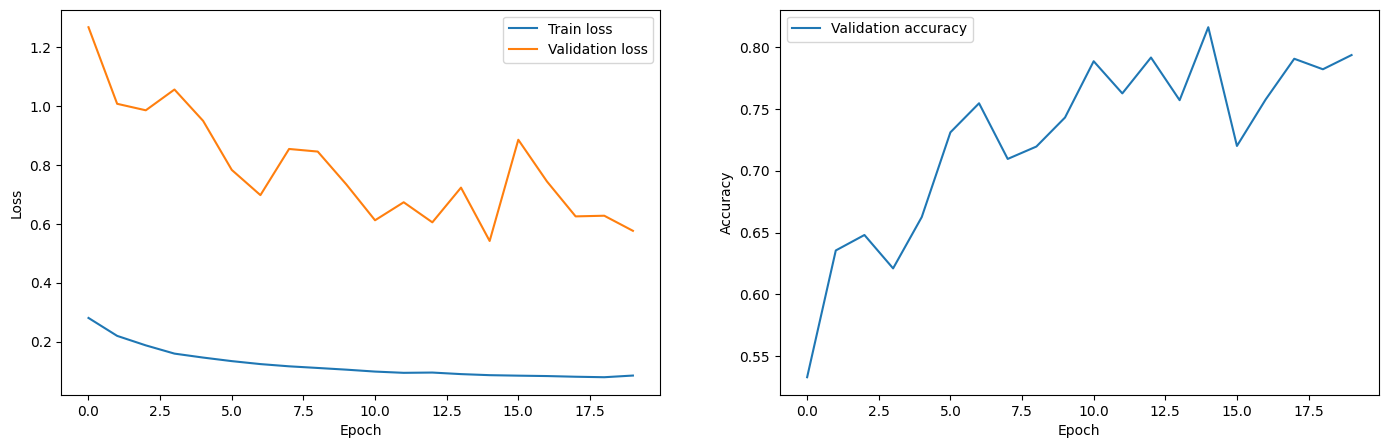

In [11]:
# Visualize the training and validation losses
import json
import matplotlib.pyplot as plt

with open('./outputs/metrics.json') as json_file:
    scores = json.load(json_file)

train_losses = scores['train_losses']
valid_losses = scores['valid_losses']
valid_accuracies = scores['valid_accuracies']

fig, axes = plt.subplots(1, 2, figsize=(17, 5))
axes[0].plot(train_losses, label='Train loss')
axes[0].plot(valid_losses, label='Validation loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot(valid_accuracies, label='Validation accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.show()

As evident from the results, there is a notable disparity between the training and validation losses, signifying a significant difference in model performance on the two datasets. This rapid convergence during training aligns with the observations made by the authors, who noted the model's tendency to quickly succumb to overfitting. To address this challenge, they employed dropout, a technique that `"reduces complex co-adaptations of neurons, since a neuron cannot rely on the presence of particular other neurons. It is, therefore, forced to learn more robust features that are useful in conjunction with many different random subsets of the other neurons"`

Additionally, the authors augmented their data, effectively increasing the dataset's size by a factor of 2048 which helped them avoid the use of smaller architectures (`"Without this scheme, our network suffers from substantial overfitting, which would have forced us to use much smaller networks."`). Given that our dataset is comparatively much smaller, it is unsurprising that our model also exhibits rapid convergence during training. Consequently, this leads to a significant discrepancy between the training and validation loss, underscoring the impact of dataset size on model generalization.

# Test

In [12]:
import torch

# Define a test function
def test(model, test_loader):
    """
    Evaluate a neural network model on a test set.

    Parameters:
        model (nn.Module): The trained neural network model.
        test_loader (DataLoader): DataLoader for the test data.

    Returns:
        None
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move the model to the same device as inputs

    with torch.no_grad():  # Disable gradient calculation during inference
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)  # Ensure targets are on the same device

            # Forward pass
            outputs = model(inputs)

            # Get predicted labels
            _, predicted = torch.max(outputs, 1)

            # Update counts for correct and total predictions
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')


In [13]:
# Define the test data loader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

test(model, test_loader)

Test Accuracy: 80.90%


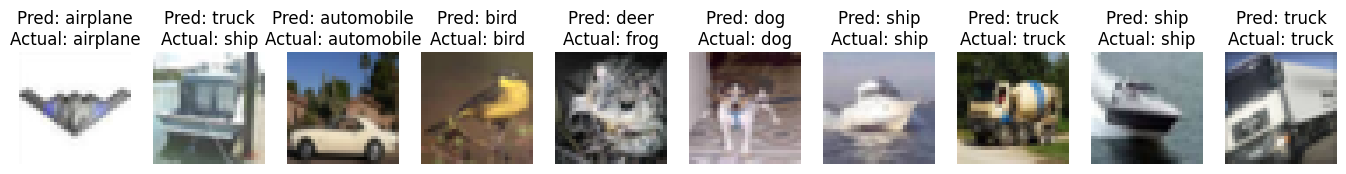

In [14]:
import random

def plot_random_predictions(model, data_loader, label_names, device):
    """
    Plot random predictions for a given model.

    Parameters:
        model (nn.Module): The trained neural network model.
        data_loader (DataLoader): DataLoader for the data.
        label_names (list): List of label names.
        device (torch.device): Device to perform computations on.

    Returns:
        None
    """
    model.eval()

    # Get random samples from the data loader
    random_samples = random.sample(range(len(data_loader.dataset)), 10)

    fig, axes = plt.subplots(1, 10, figsize=(17, 3))
    for i, idx in enumerate(random_samples):
        img, label = data_loader.dataset[idx]
        img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(img)
        _, predicted = torch.max(output, 1)

        img = img.squeeze().cpu().numpy().transpose((1, 2, 0))
        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {label_names[predicted.item()]}\nActual: {label_names[label]}")
        axes[i].axis('off')

    plt.show()

plot_random_predictions(model, test_loader, LABEL_NAMES, device)